In [144]:
import pandas as pd
import numpy
import json
import dateparser
import datetime
import seaborn as sns
import matplotlib as mpl
from scipy import stats
sns.set_style('white', {'legend.frameon':True})
mpl.rcParams['figure.figsize'] = 25, 10

In [145]:

def vek(vstup):
    try:
        vystup = int(abs(float(vstup)))/1000 if abs(float(vstup)) > 1000 else int(abs(float(vstup)))
        if vystup is not int(vystup):
            vystup *= 10
        if vystup % 100 is 0:
            vystup /= 100
        return vystup
    except ValueError:
        return numpy.nan


def datum(vstup):
    formaty = ['%Y-%m-%d', '%Y/%m/%d', '%y-%m-%d', '%d/%m/%Y']
    vstup = vstup[:10].strip()
    if not len(vstup):
        return numpy.nan
    vystup = dateparser.parse(vstup, formaty)
    if vystup is None:
        raise Exception('Nenaznamy format datumu:' + vstup)
    if vystup.year > 2018:
        vystup = vystup - datetime.timedelta(36500)     
    if vystup.year < 1900:
        vystup = datetime.datetime(1900 + vystup.year % 100, vystup.month, vystup.day)
    return vystup


konvertovace = {
    'age' : vek,
    'date_of_birth': datum
}

personalne = pd.read_csv("data/personal_train.csv", na_values='?', index_col=0, converters=konvertovace, )



Nacitane personalne data, s opravenym vekom a datumom narodenia.

In [146]:
bulo = lambda vstup: numpy.nan if pd.isna(vstup) or len(str(vstup).strip()) is 0 else str(vstup).strip().lower().split('.')[0][0] == 't'
classa = lambda vstup: vstup.lower().split('.|')[0]


def js(vstup):
    try:
        return str(vstup).replace("'", '"')
    except json.JSONDecodeError:
        pass

konvertovace = {
    "FTI measured": bulo,
    "tumor": bulo,
    "lithium": bulo,
    "thyroid surgery": bulo,
    "I131 treatment": bulo,
    "goitre": bulo,
    "hypopituitary": bulo,
    "query on thyroxine": bulo,
    "T3 measured": bulo,
    "TBG measured": bulo,
    "pregnant": bulo,
    "class": classa,
    "medical_info": js
}
other = pd.read_csv("data/other_train.csv", na_values=['?', '??', ' ?'], index_col=0, true_values=['t'],
                    false_values=['f'],
                    converters=konvertovace)
other = other.drop(columns=['TBG'])


Nacitane ostatne udaje s opravenymi boolovskymi hodnotami a vyhodenym prazdnym stlpcom TBG

In [147]:
def rozober_json(vstup):
    try:
        return pd.Series(json.loads(vstup))
    except json.JSONDecodeError:
        return pd.Series(json.loads('{}'))
other = other.join(other['medical_info'].apply(rozober_json))
other = other.drop(columns='medical_info')

Rozoberanie jsonu v medical_info stlpci na jednotlive stlpce

In [148]:
for stlpec in ['TSH measured', 'query hyperthyroid', 'TT4 measured', 'on antithyroid medication', 'sick', 'T4U measured', 'psych', 'query hypothyroid']:
    other[stlpec] = other[stlpec].apply(bulo)

other = other.replace('?', numpy.nan)

Oprava pridanych boolovskych stlpcov a nahradenie ? za NaN

In [149]:
vsetko = other.merge(personalne, on=('name', 'address'))
vsetko = vsetko.replace(to_replace=[None], value=numpy.nan)

Spojenie suborov a nahradenie None za NaN

In [150]:
def agreguj(vstup):
    vstup = vstup.reset_index()
    for hodnota in vstup.values:
        if not pd.isna(hodnota[1]) and str(hodnota[1]).strip() != '':
            return hodnota[1]
    return numpy.nan

In [151]:
vsetko = vsetko.groupby(['name', 'address']).aggregate(agreguj).reset_index()

Spojenie rovnakych riadkov. Momentalne berieme prvu neprazdnu hodnotu. V pripade ze by bolo neprazdnych hodnot viac, dal by sa pouzit priemer pre numericke atributy a modus pre kategoricke, pripadne najcastejsia hodnota v celom datasete ak by pocet vyskytov bol rovnaky.

In [152]:
vsetko.FTI = pd.to_numeric(vsetko.FTI)

In [153]:
vsetko = vsetko[vsetko['class']!='']

Odstranenie riadkov s prazdnou hodnotou class - tieto riadky by nam pri trenovani nepomohli

In [154]:
nenumericke = vsetko.select_dtypes(exclude=numpy.number).columns
modusy = {}
for stlpec in nenumericke:
    modusy[stlpec] = vsetko[stlpec].mode()
vsetko = vsetko.replace(numpy.nan, value=modusy)


Doplnenie kategorickych atributov najcastejsou hodnotou

In [155]:
numericke = vsetko.select_dtypes(include=numpy.number).columns
mediany = {}
for stlpec in numericke:
    mediany[stlpec] = vsetko[stlpec].median()
medianove = vsetko.replace(numpy.nan, value=mediany)

Doplnenie chybajucich hodnot numerickych atributov medianom

In [156]:

def priemeraj(s): #s ako nazov stlpca pochopitelne...
    priemery = {}
    for hodnota in vsetko[s].unique():
        priemery[hodnota] = {}
        for stlpec in numericke:
            priemery[hodnota][stlpec] = vsetko[vsetko[s]==hodnota][stlpec].mean()
    priemerove = []
    # for stlpec in numericke:
    for hodnota in vsetko[s].unique():
        priemerove.append(vsetko[vsetko[s]==hodnota].replace(numpy.nan, value=priemery[hodnota]))
    return pd.concat(priemerove)


In [157]:
priemerove = priemeraj('occupation')

Doplnenie chybajucich numerickych atributov pomocou priemerov segmentov podla stlpca occupation.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61d34c6518>,
      dtype=object)

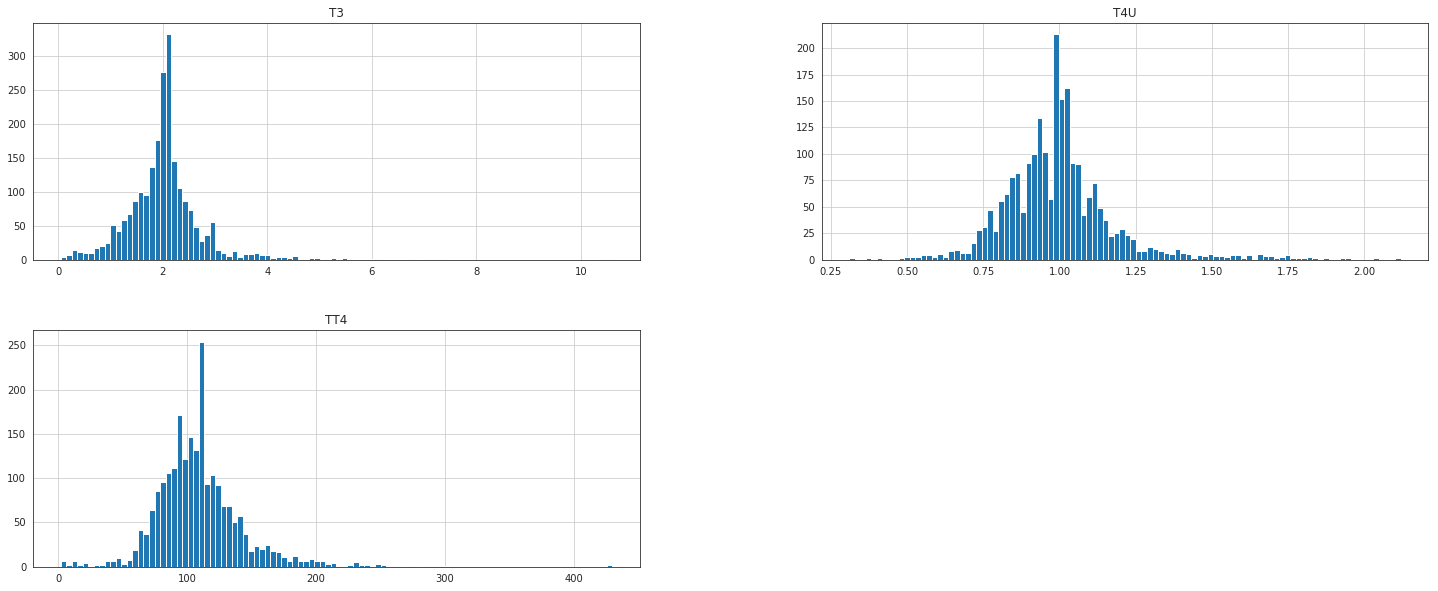

In [158]:
priemerove.hist(bins=100, column=["T4U", "TT4", "T3"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61d32019b0>,
      dtype=object)

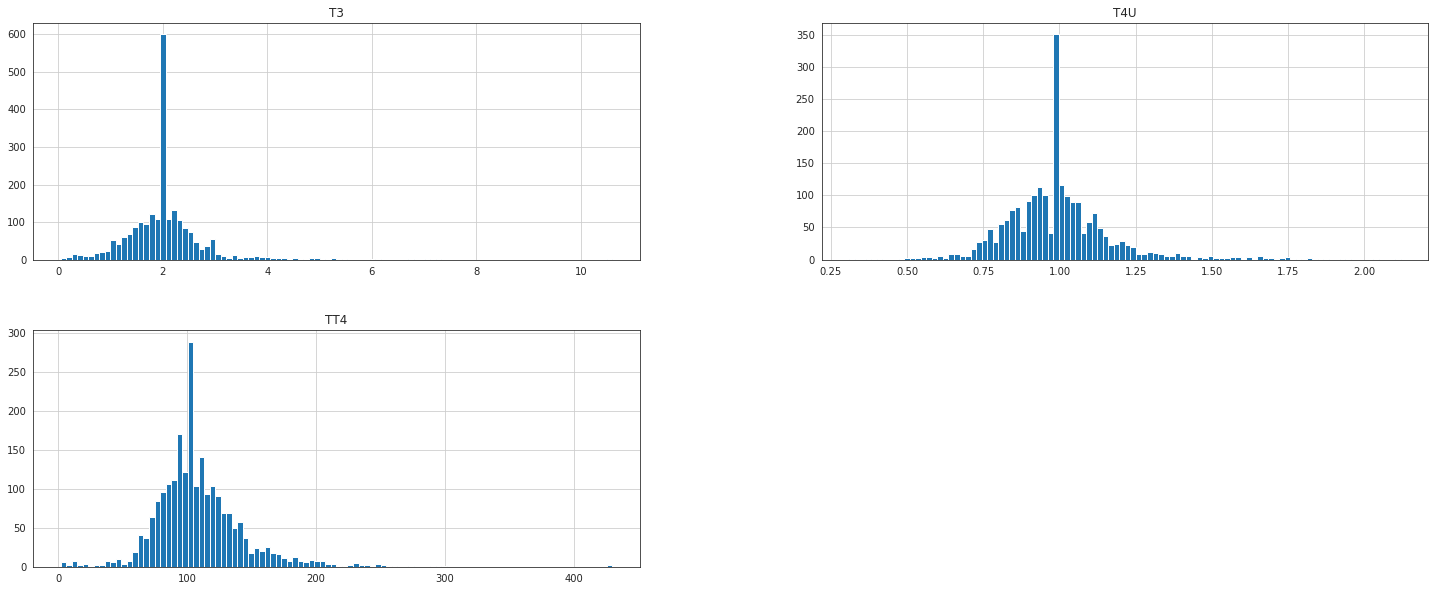

In [159]:
medianove.hist(bins=100, column=["T4U", "TT4", "T3"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61d335ff28>,
      dtype=object)

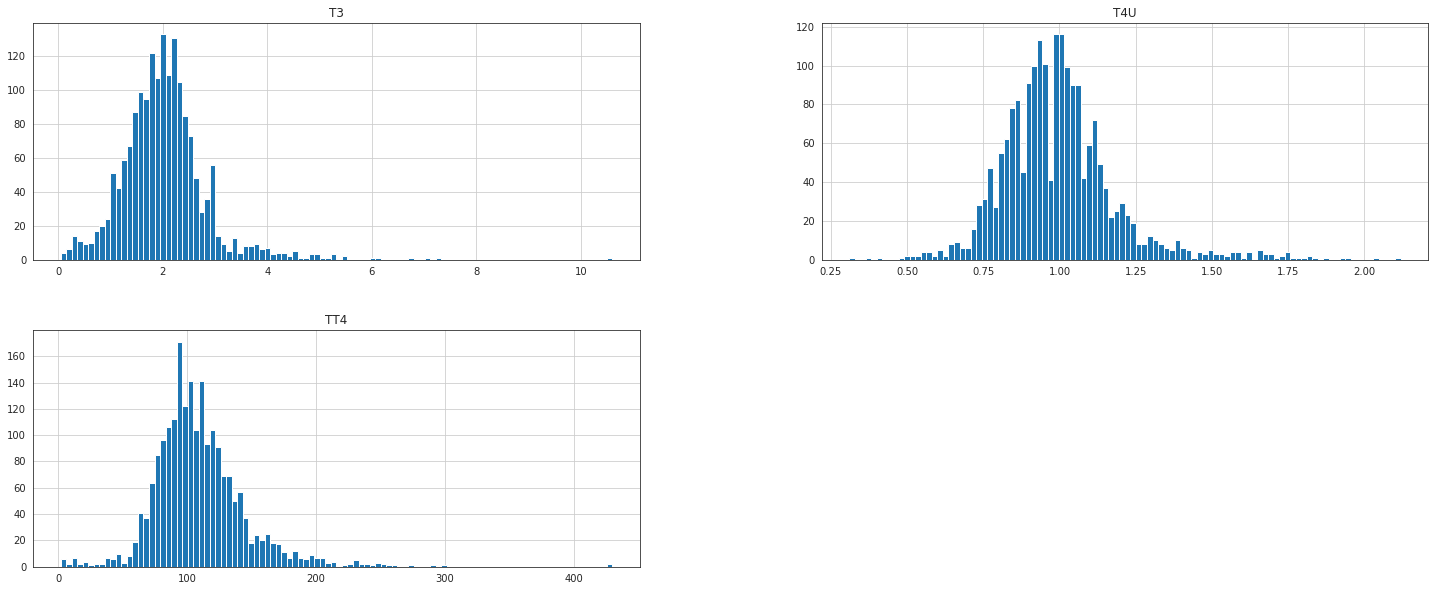

In [160]:
vsetko.hist(bins=100, column=["T4U", "TT4", "T3"])


Z vyssie uvedenych histogramov vyplyva, ze lepsie je pouzit doplnenie chybajucich hodnot pomocou priemerov segmentov.

/usr/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


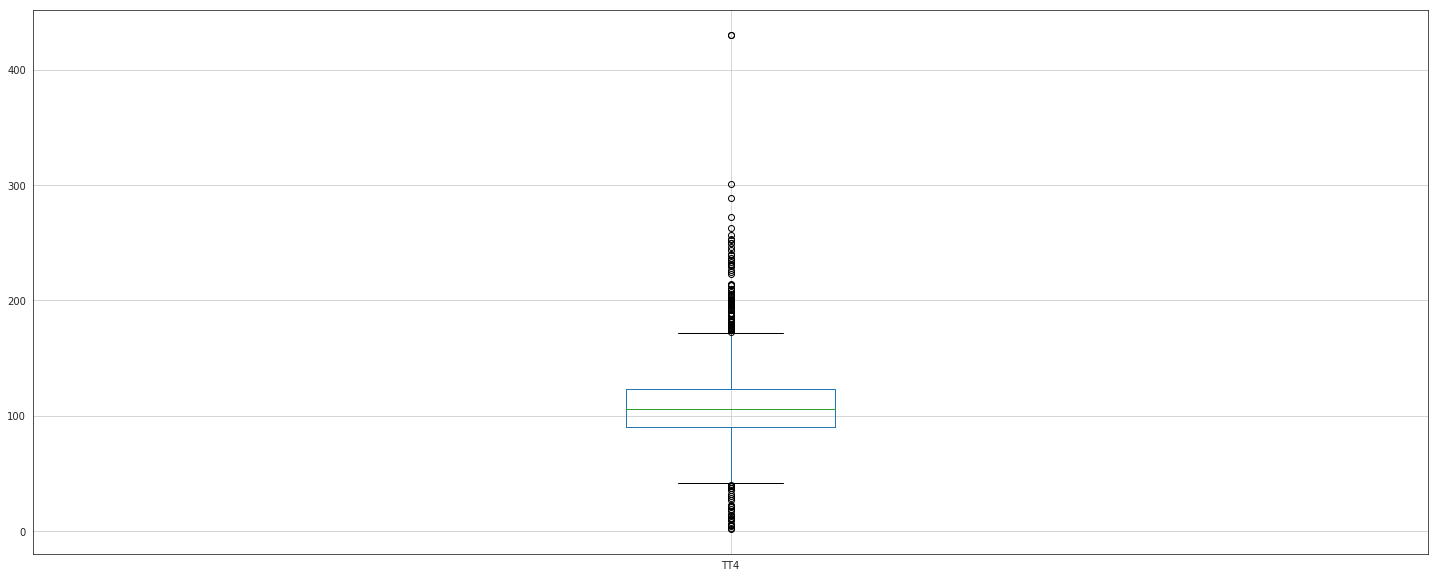

In [161]:
priemerove.boxplot(column=["TT4"])

/usr/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


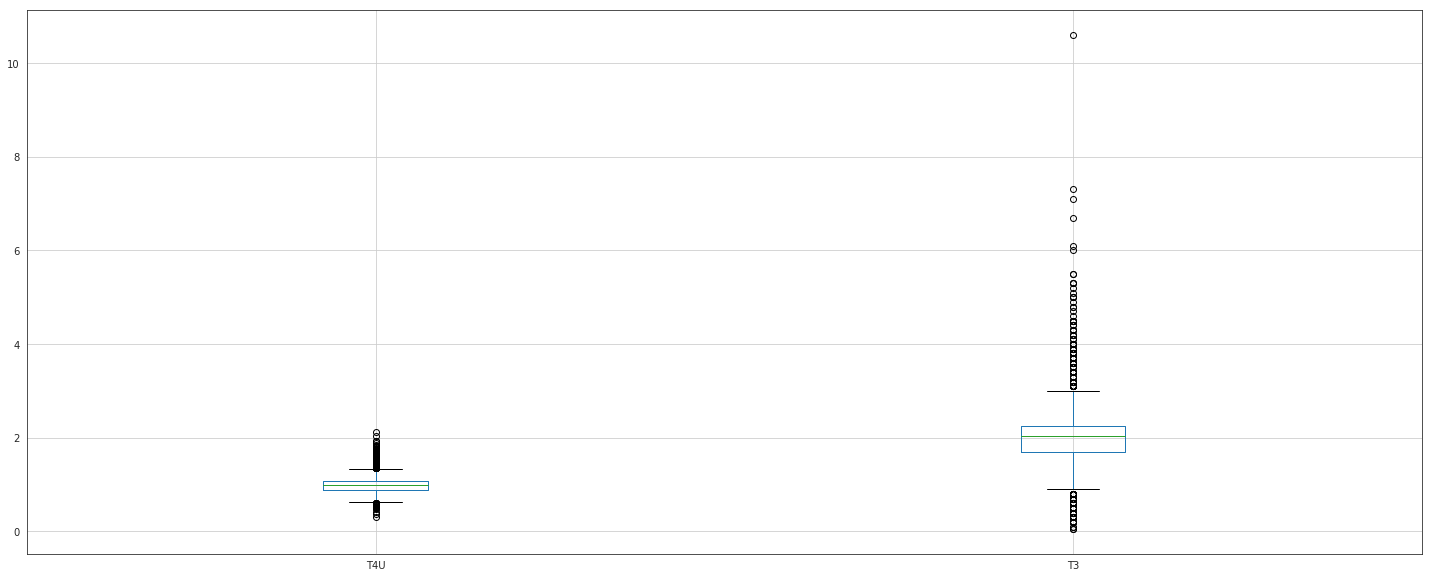

In [162]:
priemerove.boxplot(column=["T4U", "T3"])

In [175]:
vyhodeny_autlajery = priemerove[(numpy.abs(stats.zscore(priemerove.select_dtypes(numpy.number))) < 5).all(axis=1)]

/usr/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


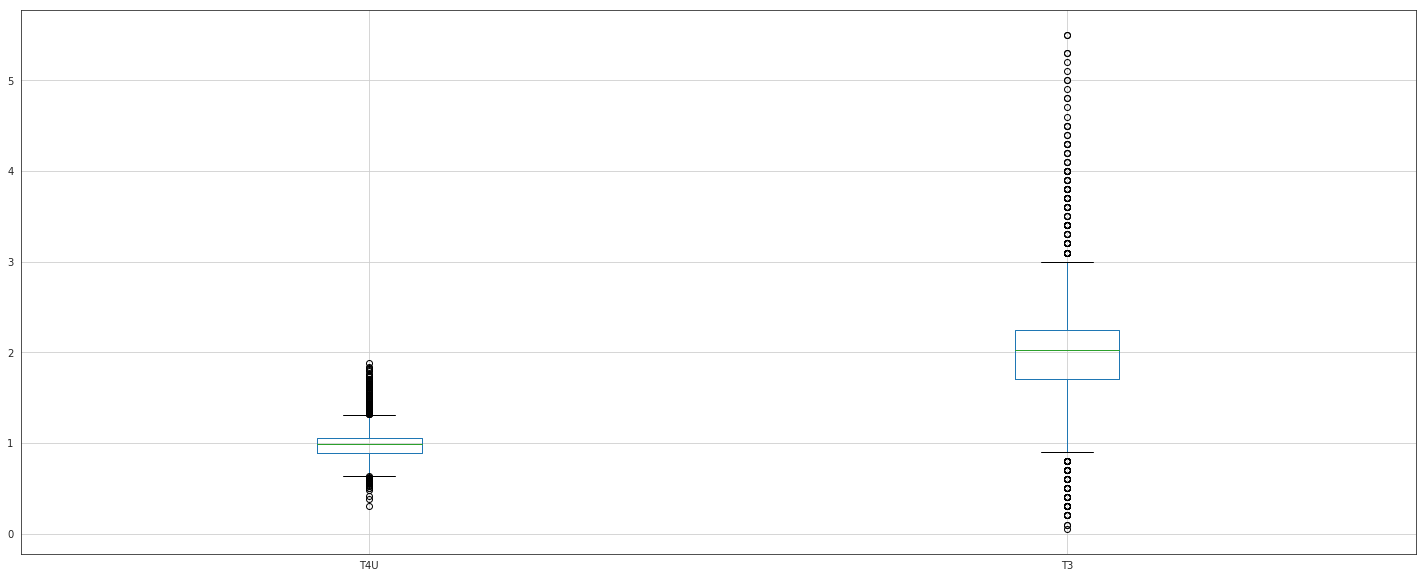

In [176]:
vyhodeny_autlajery.boxplot(column=["T4U", "T3"])

/usr/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


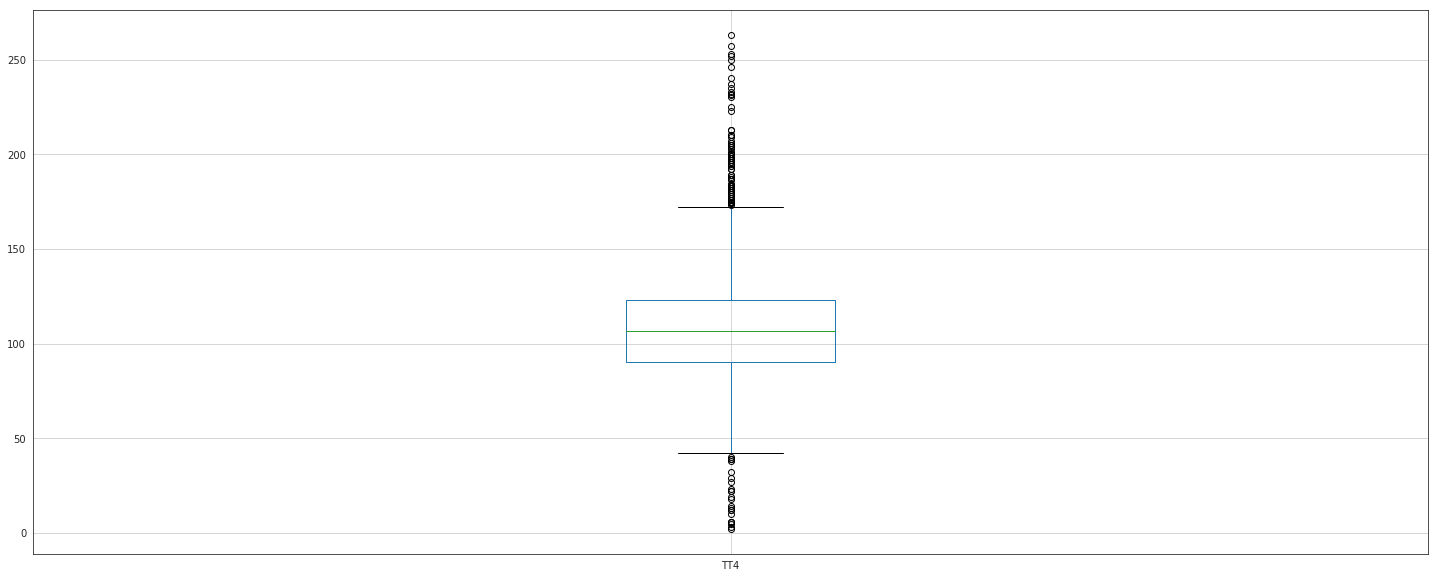

In [177]:
vyhodeny_autlajery.boxplot(column=["TT4"])

In [178]:
len(priemerove) - len(vyhodeny_autlajery)

58

Ocividne bolo odstranenych 58 riadkov

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61d25cf7b8>,
      dtype=object)

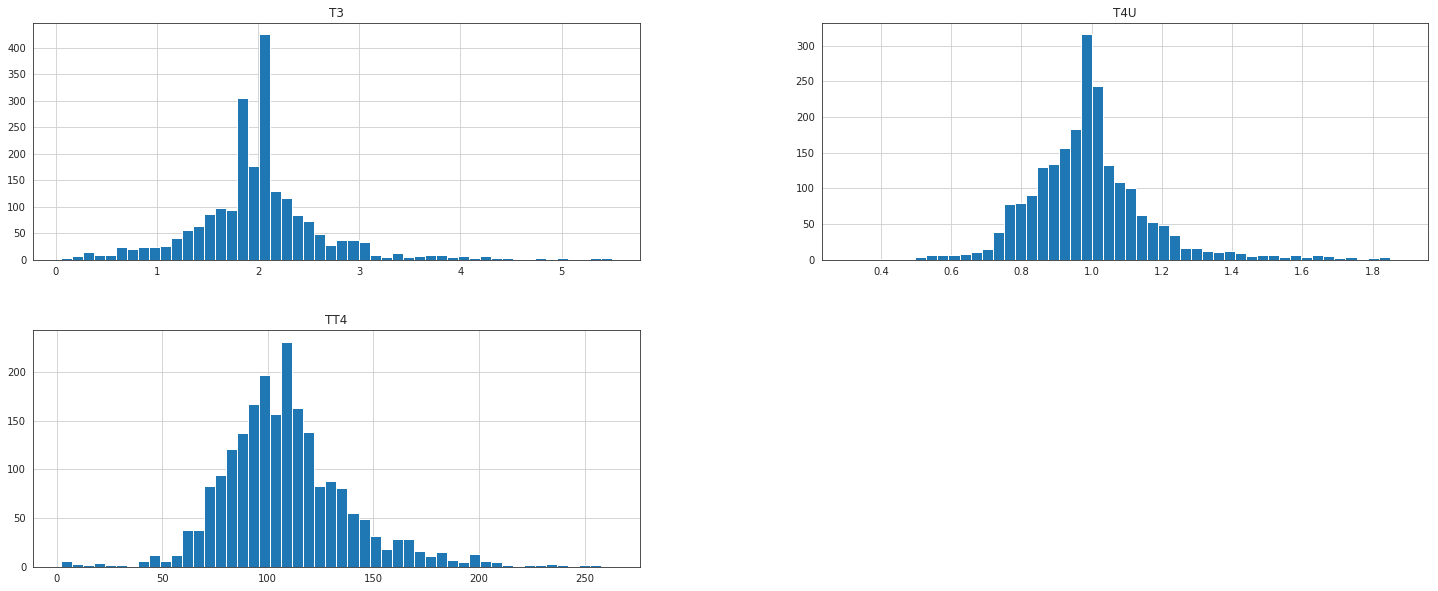

In [179]:
vyhodeny_autlajery.hist(bins=50, column=["T4U", "TT4", "T3"])

In [180]:
dolny_quantiles = priemerove.quantile(0.02)
horny_quantiles = priemerove.quantile(0.98)

Vyratanie kvantilov, ktorymi budeme nahradzati

In [181]:
nahradeny_autlajery = priemerove.mask(priemerove.select_dtypes(numpy.number) < dolny_quantiles, dolny_quantiles, axis=1)
nahradeny_autlajery = nahradeny_autlajery.mask(nahradeny_autlajery.select_dtypes(numpy.number) > horny_quantiles, horny_quantiles, axis=1)

Nahradenie vyhchylenych hodnot kvantilmi.

/usr/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


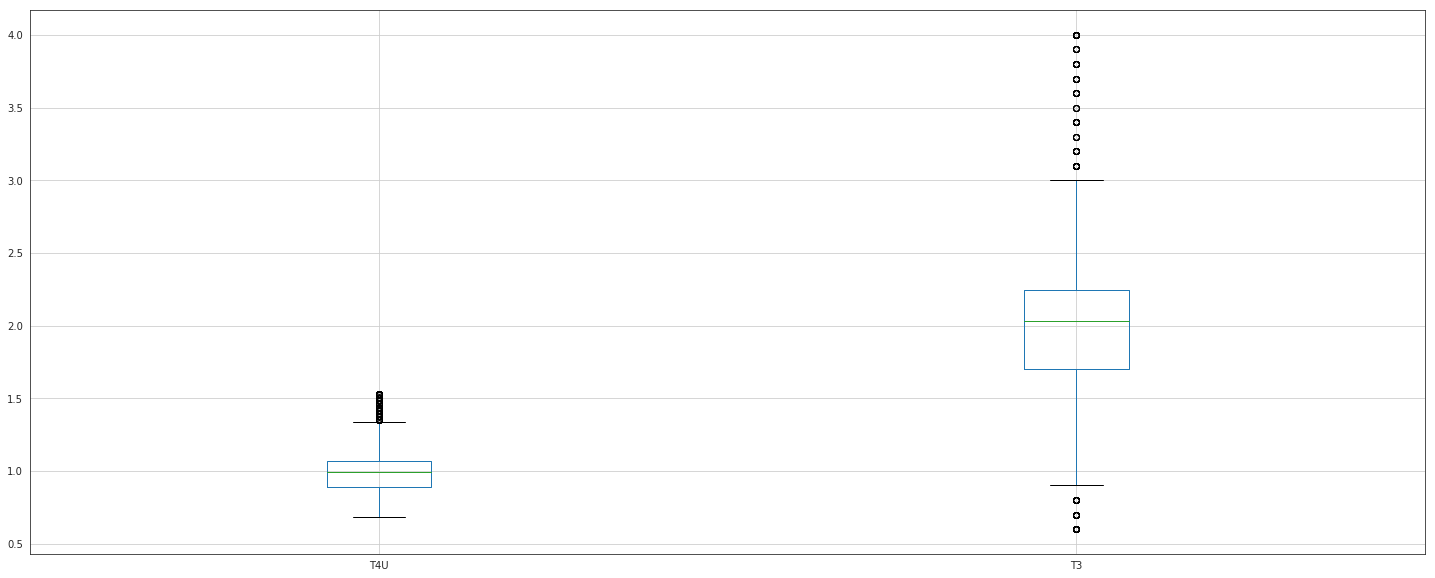

In [182]:
nahradeny_autlajery.boxplot(column=["T4U", "T3"])

/usr/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


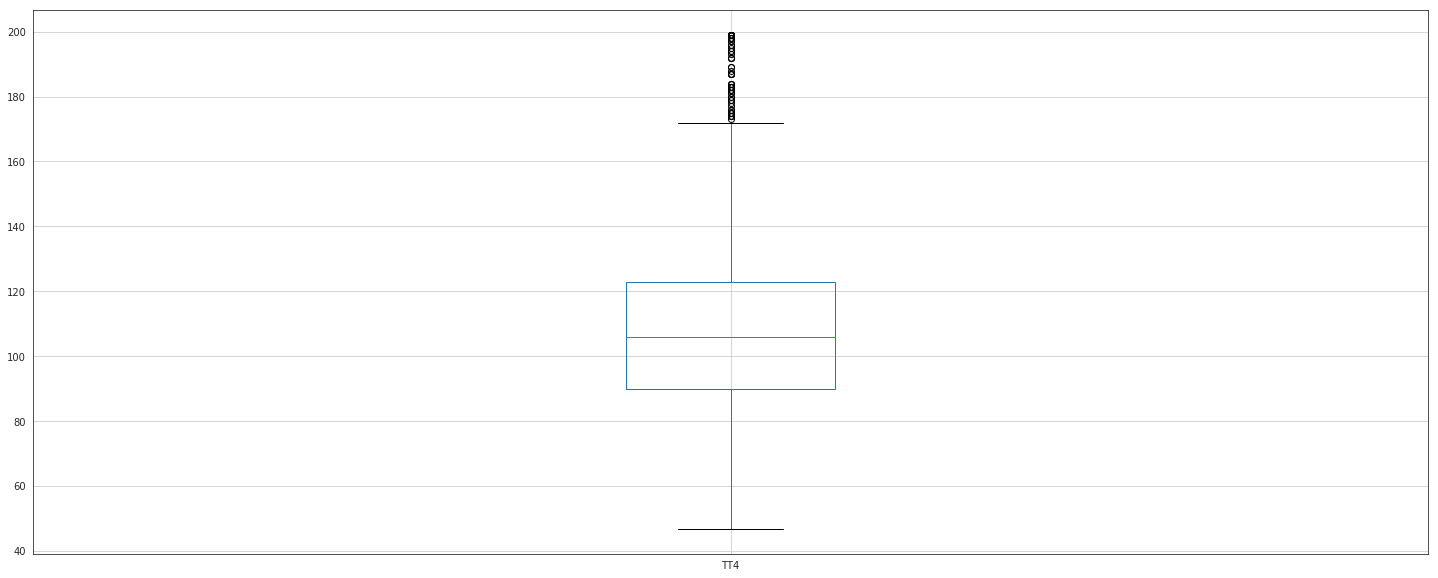

In [183]:
nahradeny_autlajery.boxplot(column=["TT4"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61d2316d30>,
      dtype=object)

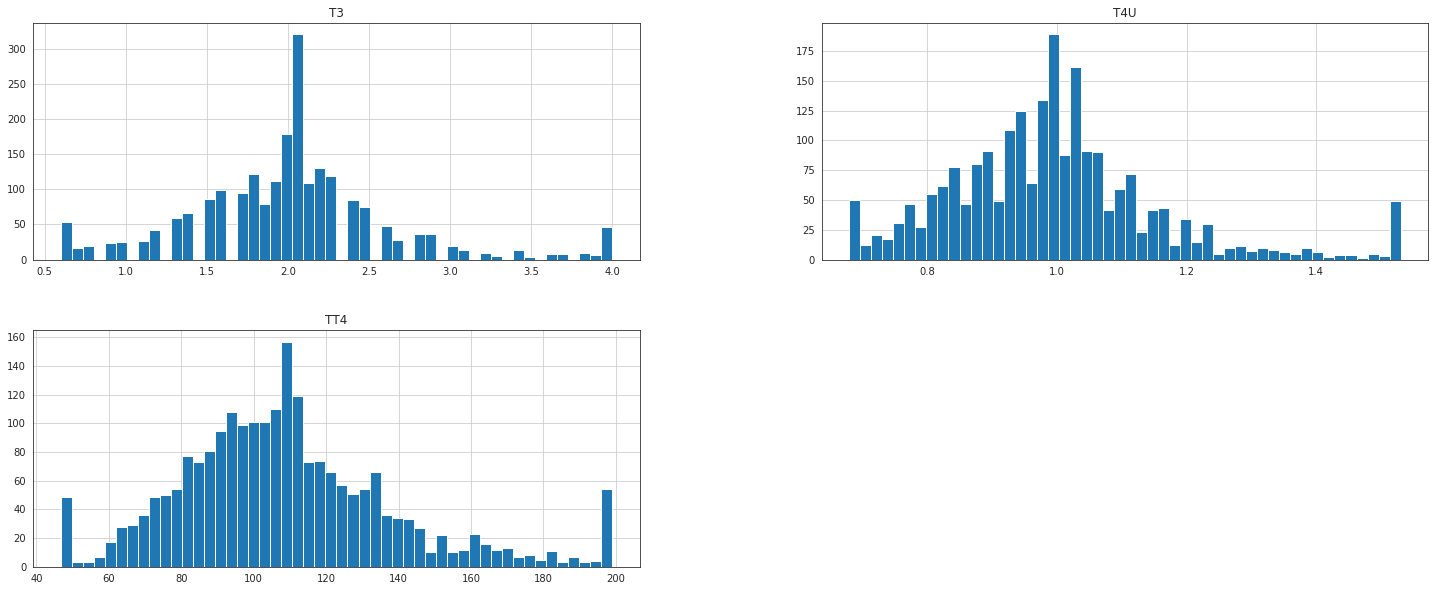

In [184]:
nahradeny_autlajery.hist(bins=50, column=["T4U", "TT4", "T3"])

Zda sa, ze vyhodenie vychylenych hodnot je lepsie, nakolko vysledne rozdelenie je rovnomernejsie.

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/usr/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


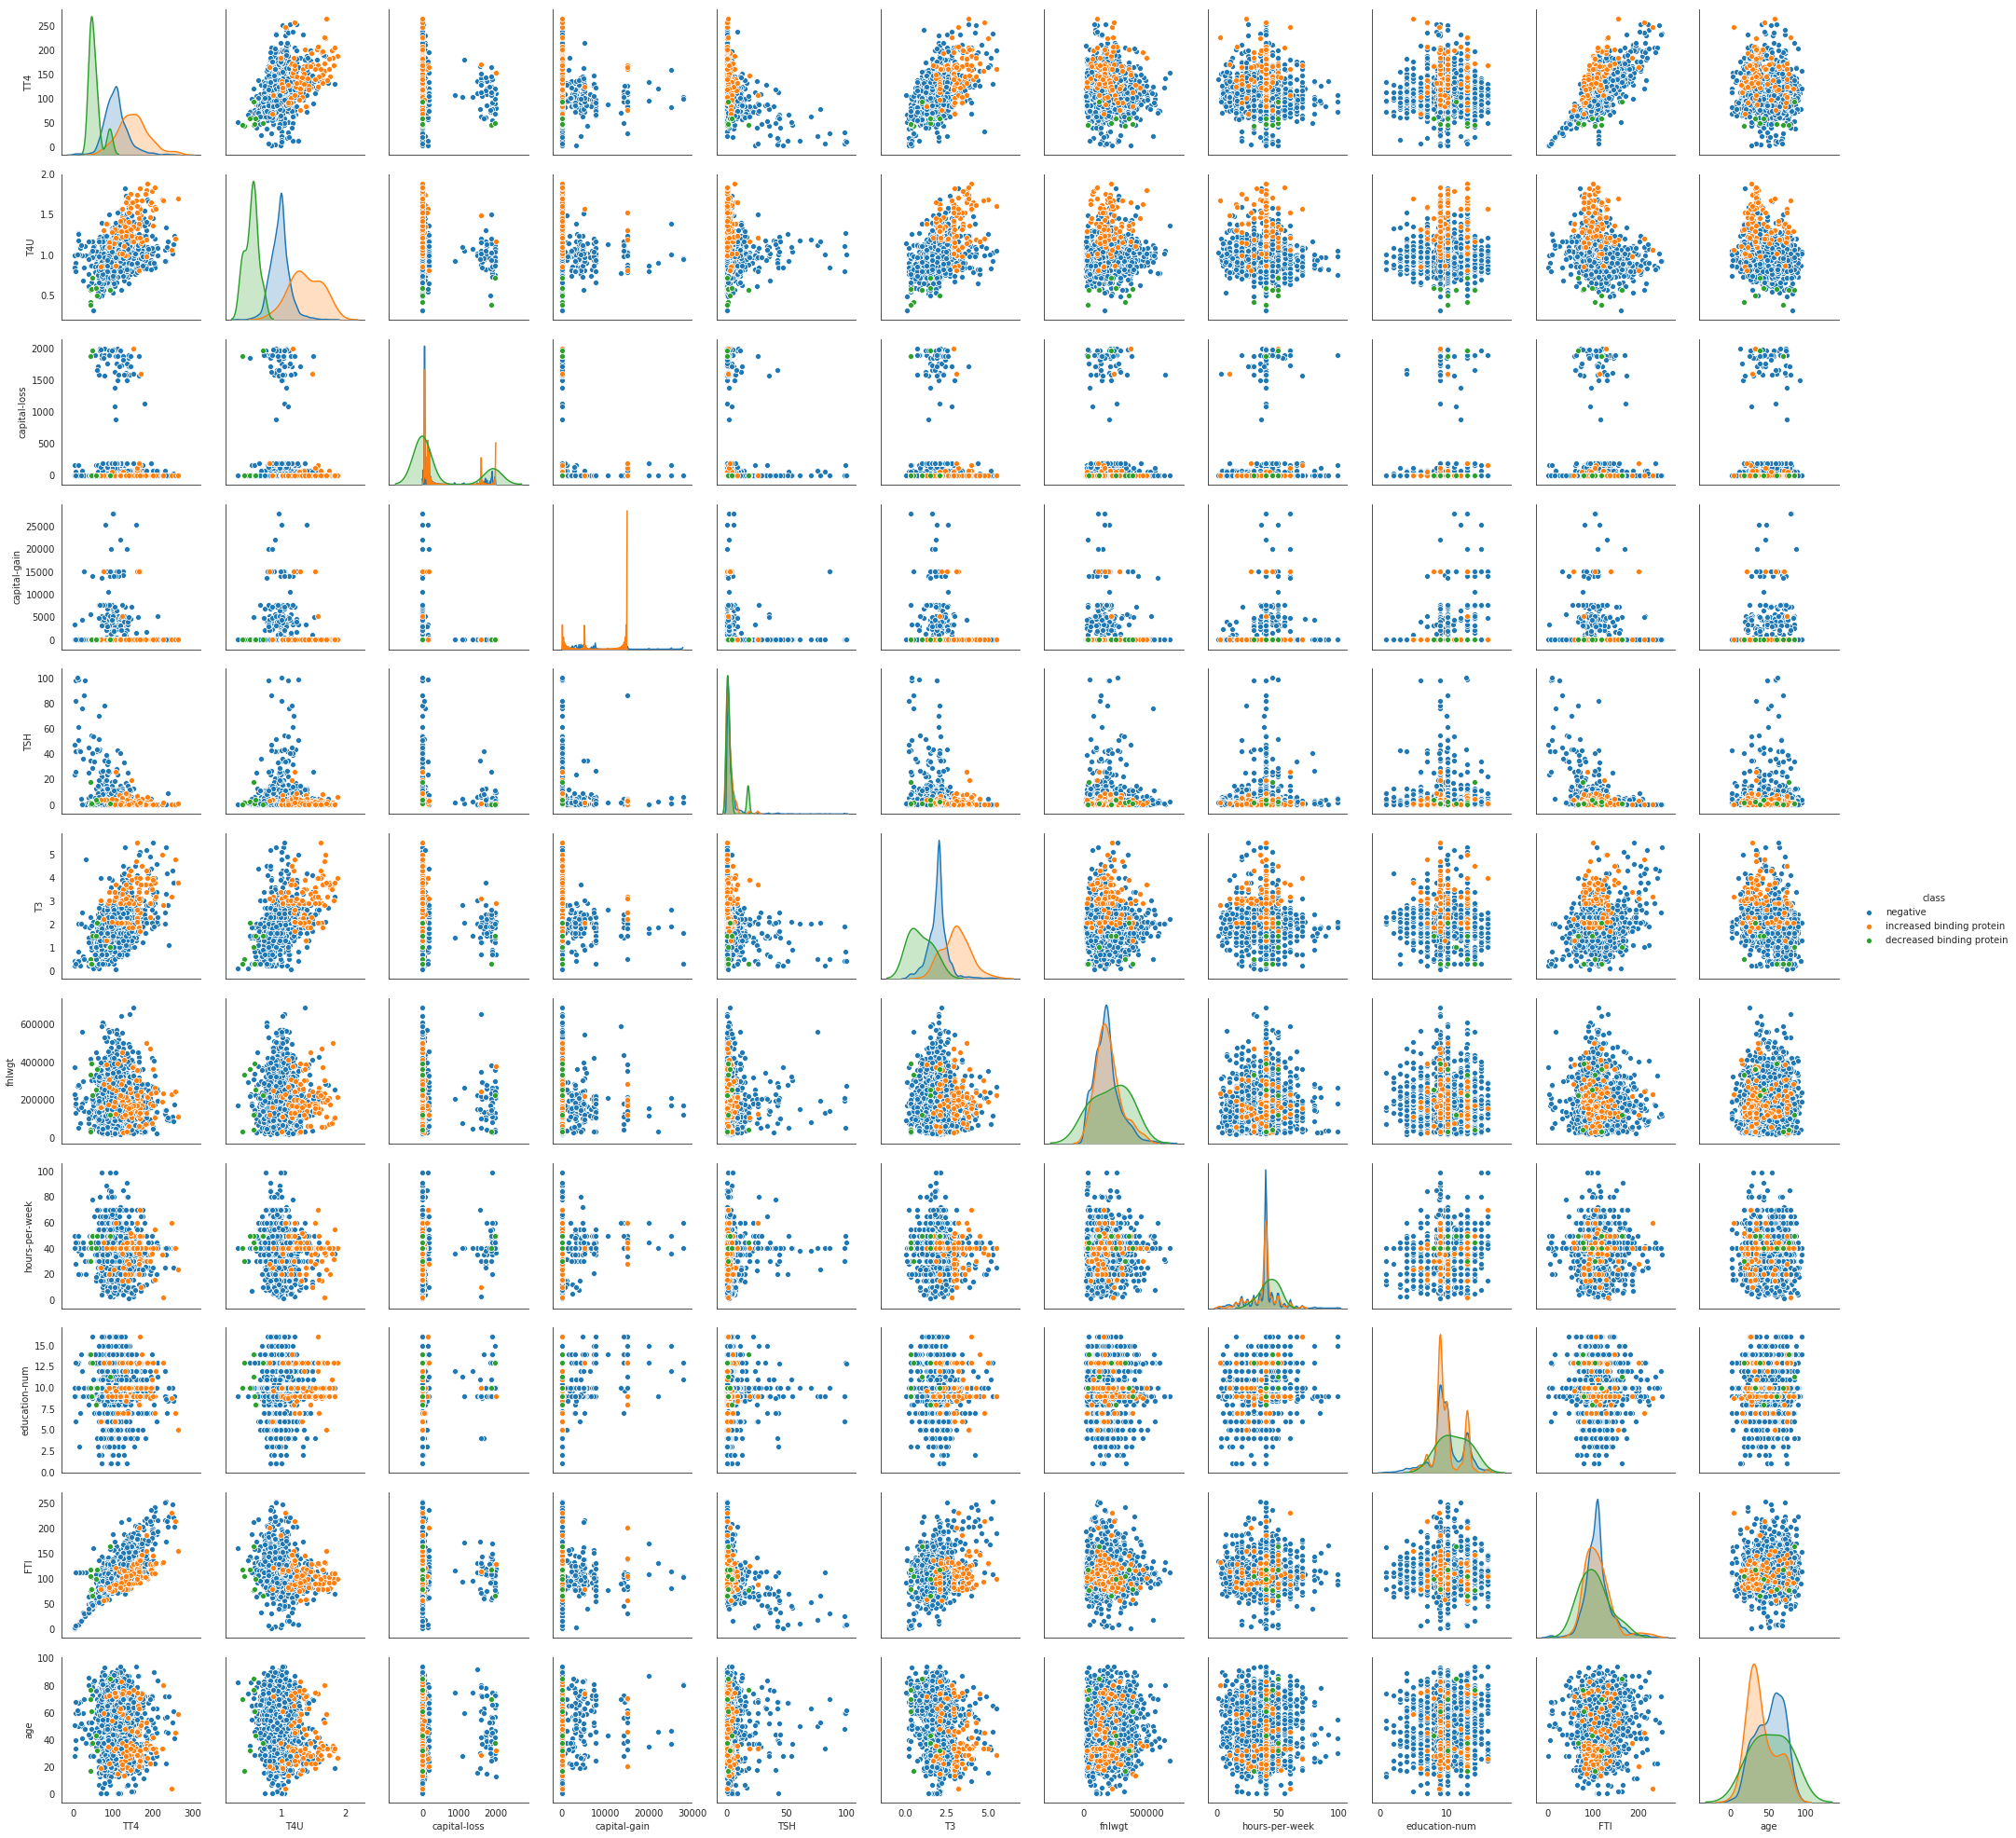

In [185]:
barco = vyhodeny_autlajery.select_dtypes(numpy.number)
barco['class'] = vyhodeny_autlajery['class'] 
sns.pairplot(barco, 'class')

Index(['TT4', 'T4U', 'capital-loss', 'capital-gain', 'TSH', 'T3', 'fnlwgt',
       'hours-per-week', 'education-num', 'FTI', 'age'],
      dtype='object')